#  Neural Network for Customer Churn Prediction


In [122]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Dropout


# Load and preprocess data


In [123]:
df = pd.read_csv('bank-customer-churn-prediction-challenge/train.csv')
df.drop([ 'CustomerId', 'Surname'], axis=1, inplace=True)
df = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)

# Split features and target


In [124]:
X = df.drop('Exited', axis=1)
y = df['Exited']

# Handle missing values


In [125]:
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Scale features


In [126]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Train-test split


In [127]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [128]:
def preprocess(df):
    df = df.copy()
    for col in ['id', 'CustomerId', 'Surname']:
        if col in df.columns:
            df.drop(col, axis=1, inplace=True)
    df = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)
    return df

# Build neural network model


In [129]:
model = Sequential([
        Input(shape=(X.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Train model


In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=1)
joblib.dump(model, 'model_neural_network.pkl')
joblib.dump(imputer, "imputer.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(X.columns, "feature_columns.pkl")

print(" Logistic model and preprocessors saved.")
print("Model saved as model_neural_network.pkl")


Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 732us/step - accuracy: 0.7999 - loss: 0.4599 - val_accuracy: 0.8747 - val_loss: 0.3050
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - accuracy: 0.8606 - loss: 0.3446 - val_accuracy: 0.8847 - val_loss: 0.2792
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - accuracy: 0.8785 - loss: 0.3123 - val_accuracy: 0.9017 - val_loss: 0.2568
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - accuracy: 0.8795 - loss: 0.3072 - val_accuracy: 0.9030 - val_loss: 0.2444
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - accuracy: 0.8879 - loss: 0.2818 - val_accuracy: 0.9013 - val_loss: 0.2389
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - accuracy: 0.8879 - loss: 0.2777 - val_accuracy: 0.9040 - val_loss: 0.2397
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - accuracy: 0.8900 - loss: 0.2759 - val_accuracy: 0.9063 - val_loss: 0.2378
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - accuracy: 0.8951 - loss: 0.2685 - 

# Evaluate model


In [131]:
y_pred_proba = model.predict(X_val).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

acc = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_proba)

print(f'Accuracy: {acc:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(classification_report(y_val, y_pred))

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step
Accuracy: 0.9067
F1 Score: 0.7363
ROC AUC: 0.9369
              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94      2413
         1.0       0.82      0.67      0.74       587

    accuracy                           0.91      3000
   macro avg       0.87      0.82      0.84      3000
weighted avg       0.90      0.91      0.90      3000



# Accuracy


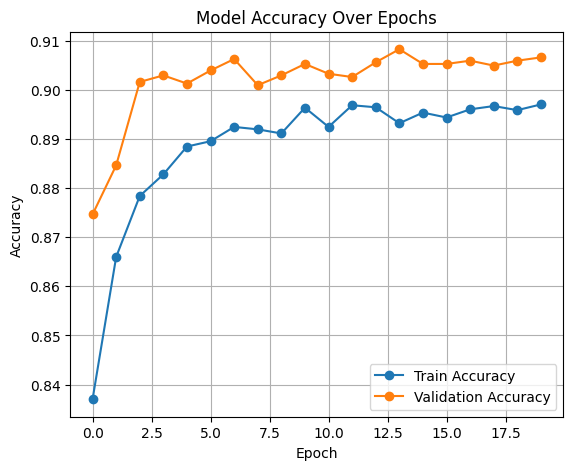

In [132]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss


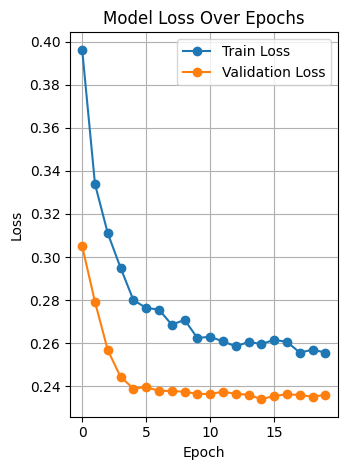

In [133]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Load Test Data

In [134]:

test_df = pd.read_csv("bank-customer-churn-prediction-challenge/test.csv")

# Preprocess
X_test_raw = preprocess(test_df)

# Align columns with training set
feature_columns = joblib.load("feature_columns.pkl")
X_test_raw = X_test_raw.reindex(columns=feature_columns, fill_value=0)
# Apply imputer and scaler
imputer = joblib.load("imputer.pkl")
scaler = joblib.load("scaler.pkl")
X_test_imputed = imputer.transform(X_test_raw)
X_test_scaled = scaler.transform(X_test_imputed)

# Load model and predict probabilities
model = joblib.load("model_neural_network.pkl")
probas = model.predict(X_test_scaled).flatten()
# Build submission
submission = pd.DataFrame({
    'id': test_df['id'] if 'id' in test_df.columns else test_df['CustomerId'],
    'Exited': probas
})
submission.to_csv("submission_nn.csv", index=False)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
